# MBA FIAP Inteligência Artificial & Machine Learning

## Visão Computacional Capstone
## Processamento de imagens aplicada a auditoria automática de vídeo baseada em modelos de deep-learning


Este projeto final tem como objetivo explorar os conhecimentos adquiridos nas aulas práticas. Por meio uma trilha guiada para construir uma aplicação que tem por objetivo analisar imagens e extrair uma série de informações que serão utilizadas para compor uma análise de imagens e vídeos afim de construir uma forma de auditoria automatizada baseado em modelos de inteligência artificial.


<p align="center">
<img src="imagens-aux/example.png">
</p>


Este projeto poderá ser feita por grupos de até 4 pessoas.

| Nome dos Integrantes     | RM            | Turma |
| :----------------------- | :------------- | :-----: |
| Integrante 1             | RM 12345      | `1IA` |
| Integrante 2             | RM 12345      | `1IA` |
| Integrante 3             | RM 12345      | `1IA` |
| Integrante 4             | RM 12345      | `1IA` |

Por ser um projeto guiado, fique atento quando houver as marcações **Implementação** indica que é necessário realizar alguma implementação em Python no bloco a seguir onde há a inscrição ```## IMPLEMENTAR``` e **Resposta** indica que é esperado uma resposta objetiva relacionado a algum questionamento. 

**Cada grupo pode utilizar nas respostas objetivas quaisquer itens necessários que enriqueçam seu ponto vista, como gráficos, fotos e, até mesmo, trechos de código-fonte.**

Pode-se utilizar quantos blocos forem necessários para realizar determinadas implementações ou utilizá-las para justificar as respostas. Não é obrigatório utilizar somente o bloco indicado.

Ao final não se esqueça de subir os arquivos do projeto nas contas do GitHub de cada membro, ou subir na do representante do grupo e os membros realizarem o fork do projeto.

A avaliação terá mais ênfase nos seguintes tópicos de desenvolvimento do projeto:
 
1. __Modelo de identificação de idades__
2. __Modelo de identificação de gênero__
3. __Extração de faces (região de interesse)__
4. __Análise de vídeo e extração de objetos__
5. __Conclusões Finais__

Para cada item haverá uma métrica de sucesso a ser perseguida e recomendações de como atingi-la. De todo modo os grupos terão liberdade para propor abordagem _ligeiramente_ diferentes para atinger as mesmas métricas. Apenas fica vetado o uso de APIs baseadas em cloud.

> **Dúvidas**: clique [aqui](https://github.com/michelpf/fiap-ml-visao-computacional-capstone/issues/new) para perguntar e abrir uma _issue_.

Requisitos mínimos para execução deste projeto:

* Keras
* Scikit-learn
* Seaborn
* DLib
* OpenCv
* Pandas
* Numpy

Para verificar se possui os pacotes obrigatórios execute os comandos abaixo de importação.

In [1]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd
import os

import time

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

** Importante ressaltar que precisamos do OpenCV >= 3.4.2.**

Execute o comando a baixo para verificar. Se obter versão menor que 3.4.2, instale a versão correta e depois prossiga com o projeto.

In [2]:
print(cv2.__version__)

4.1.2


## 5. Identificação de objetos

Além de identificarmos as pessoas, precisamos também identificar diferentes objetos.
Uma forma de alcançarmos tal objetivo é utilizar um modelo já treinado com diversos objetos treinados.

O modolo Yolov3, por exemplo, possui 80 diferentes objetos em seu modelo, servindo muito bem para o propósito do desafio.

### 5.1 Configurando o modelo Yolov3

Primeiramente baixe os pesos diretamente no site do Darknet, neste [link](https://pjreddie.com/media/files/yolov3.weights). Copie o arquivo ```yolov3.weights``` para a pasta pesos.
Confira o arquivo ```yolo-classes/coco.anmes```. Estas são as classes de todos os objetos que são possíveis identificar.
Por fim, verifique se o arquivo ```config/yolov3.cfg``` está presente. Não é necessário ajustar nenhum parâmetro nele.

In [3]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

#Exibição na mesma tela do Jupyter
%matplotlib inline

from os import listdir
from os.path import isfile, join

import pandas as pd

#...

import os

import time

plt.style.use('seaborn')
sns.set_style("whitegrid", {'axes.grid' : False})

In [4]:
print(cv2.__version__)

4.1.2


In [5]:
# Carregar os labels do conjunto de dados Coco
label_path = "yolo-classes/coco.names"
labels = open(label_path).read().strip().split("\n")

# Atribuir a cada label uma cor diferente (randômica)
np.random.seed(42)
cores = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

# Definir caminho dos arquivos de pesos e configuração
pesos_path ="pesos/yolov3.weights"
config_path = "config/yolov3.cfg"

# Carregar a rede
net = cv2.dnn.readNetFromDarknet(config_path, pesos_path)

Se o código carregou as configurações sem erros, estamos prontos para avançar.

Os valores de confiança e supressão não máxima são atributes importantes para o processo de detecção de objetos. Escolha valores adequados que permitam a detecção aceitável e com valores próximos os critérios de sucesso apresentandos mais adiante.

Os valores precisam ser numéricos fracionários. Sendo que 1 é igual a 100%. Valores médios costumam apresentar performance razoável.

In [6]:
#conf_threshold = 0.5
#nms_threshold = 0.4

conf_threshold = 0.3
nms_threshold = 0.6

**Pergunta:** Qual é a influência do parâmetro de confiança e supressão não máxima na performance do modelo?

**Resposta:**
 a confiança significa a probabilidade de o objeto ser o realmente desejado
 a supressão não máxima é o número de interseções entre os objetos encontrados
 Quanto menor a confiança, maior o número de objetos possivelmente encontrados, porém é exigido um processamento maior na imagem. Para o parâmetro de supressão não máxima, quanto menor seu valor, maior o número de intercecções o modelo realizará e portanto maior número de cálculos sobre os objetos encontrados.

### 5.2 Obtendo região de interesse e coordenadas

De forma semelhante que foi feito na identificação de faces, vamos fazer para a identificação de objetos.
Na função abaixo vamos implementar um algoritmo que retornará em um dicionário os valores do recorte da imagem, o que chamamos de região de interesse e suas coordenadas x, y, w e h.

A entrada da função é uma imagem colorida e uma lista de objetos para identificar, no formato de lista.
Sua saída, é uma lista de objetos no seguinte formato:

```json
[{'coordenadas': [array([589, 290, 386, 386])],
  'objeto': array([[[38, 21, 19],
          [40, 21, 20],
          [41, 22, 20],
          ...,
          [36, 19, 13],
          [37, 20, 15],
          [40, 23, 18]],...}]
```

Onde ```coordenadas``` é uma lista das coordenadas x, y, w e h no formato array, igual ao que foi apresentado anteriormente: ```[np.array(lista_coordenadas)]```. E ```objeto``` é a região de interesse do objeto extraído, igual ao que foi apresentado anteriormente: ```imagem[y:y+h, x:x+w]```.

In [7]:
def obter_objetos(imagem, lista_objetos):
    
    (H, W) = imagem.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(imagem, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    #start = time.time()
    layerOutputs = net.forward(ln)
    #end = time.time()
    
    #print("YOLO performou em {:.6f} segundos".format(end - start))
    
    boxes = []
    confidences = []
    classIDs = []
    objetos = []

    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
            
            if labels[classIDs[i]] in lista_objetos:
                print("Identificado " + text)
                
                # IMPLEMENTAR
                item = {"objeto": imagem[:y+h,:x+w], "coordenadas": [np.array((x, y) + (w, h))]}
                
                objetos.append(item)
                
    return objetos

Vamos utilizar outra imagem de testes para validar o algoritmo.

In [8]:
imagem_inferencia = cv2.imread("testes/teste-9.png")
imagem_inferencia = cv2.cvtColor(imagem_inferencia, cv2.COLOR_BGR2RGB)

Na variável ```lista_objetos``` preecha com uma lista de Strings com os valores "pessoa" e "gravata" que são os objetos a serem identificados.

In [9]:
# IMPLEMENTAR
lista_objetos = ["pessoa", "gravata"]

Execute a função com a lista definida.

In [10]:
objetos = obter_objetos(imagem_inferencia, lista_objetos)

Identificado pessoa: 0.9927
Identificado pessoa: 0.9665
Identificado pessoa: 0.9440
Identificado pessoa: 0.9264
Identificado pessoa: 0.9150
Identificado gravata: 0.7960
Identificado pessoa: 0.7253
Identificado gravata: 0.3442


Para nos certificamos que a identificação está correta, vamos desenhar um retângulo delimitador na imagem e verificar como foi a identificação.

Neste caso vamos utilizar o parâmetro ```coordenadas``` do retorno da função para cada objeto identificado.

In [11]:
imagem_anotada = imagem_inferencia.copy()
for obj in objetos:
    for (x,y,w,h) in obj["coordenadas"]:
        cv2.rectangle(imagem_anotada, (x,y), (x+w,y+h), (255,255,0), 2)

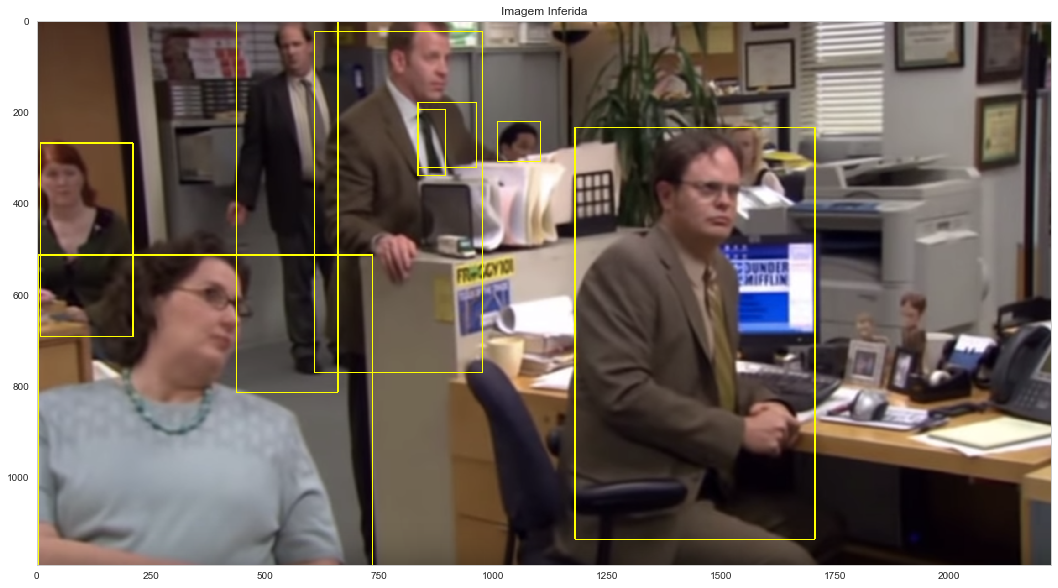

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(imagem_anotada)
plt.title("Imagem Inferida")

Vamos dar uma olhada em 3 regiões de interesse detectadas.
Lembrando que estas regiões são imagens, podemos renderizá-las diretamente no Pyplot.

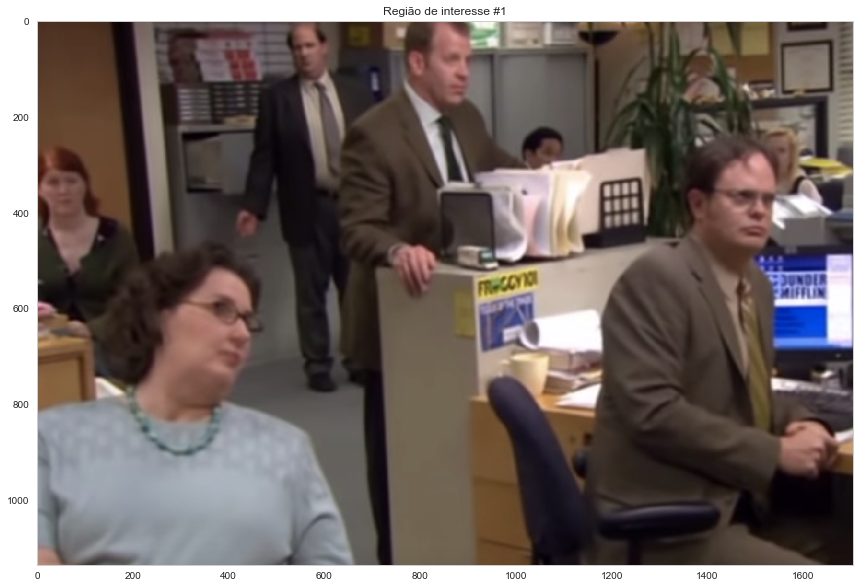

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[0]["objeto"])
plt.title("Região de interesse #1")

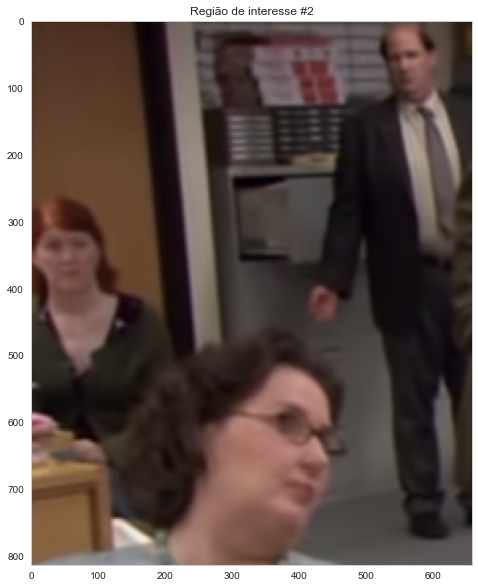

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[1]["objeto"])
plt.title("Região de interesse #2")

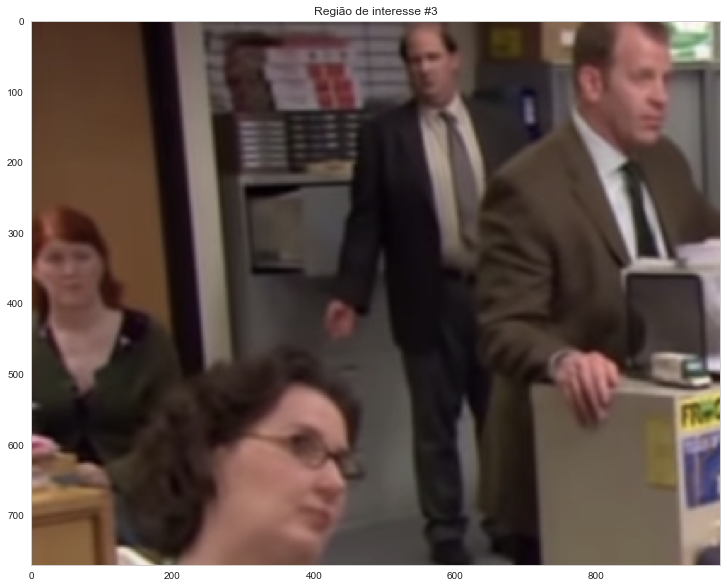

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(objetos[2]["objeto"])
plt.title("Região de interesse #3")

Perfeito, agora já estamos prontos para juntar todas as peças e começar nossa auditoria.

## 6. Auditoria automática em vídeo

Esta é a parte final do projeto.
Vamos fazer um checkpoint até aqui para ter certeza de que fizemos com sucesso os passos anteriores.

* <input type="checkbox" disabled checked> Modelo de detecção de idades treinado
* <input type="checkbox" disabled checked> Modelo de detecção de idades salvo
* <input type="checkbox" disabled checked> Modelo de detecção de idades carregado
* <input type="checkbox" disabled checked> Função de detecção de idades
* <input type="checkbox" disabled checked> Modelo de detecção de gênero treinado
* <input type="checkbox" disabled checked> Modelo de detecção de gênero salvo
* <input type="checkbox" disabled checked> Modelo de detecção de gênero carregado
* <input type="checkbox" disabled checked> Função de detecção de gênero
* <input type="checkbox" disabled checked> Função de padronização de imagens
* <input type="checkbox" disabled checked> Função de extração de faces
* <input type="checkbox" disabled checked> Função de extração de objetos

O que precisamos identificar no vídeo de auditoria:

* Homens com mais de 45 anos
* Mulheres com menos de 45 anos
* Objetos _computador portátil, celular, teclado, tv _ e _controle remoto_.

Vamos começar definindo a lista de objetos.

In [16]:
lista_objetos = ["computador portátil", "celular", "teclado", "tv", "controle remoto"]

Nesta parte vamos reunir tudo o que fizemos até aqui.
O algoritmo irá abrir um vídeo e, frame a frame, analisar seu conteúdo.
Após a instrução ```if is_capturing``` iremos implementar as verificações.

A execução abaixo pode demorar, pois será analisado individualmente cada frame do vídeo.

O que precisamos fazer:

* ```IMPLEMENTAR 1```: obter as faces de uma imagem. Neste caso receberamos uma lista de rostos no padrão que já vimos, ou seja, uma lista de ```rosto``` e ```coordenadas```.

* ```IMPLEMENTAR 2```: obter as a face de um item e padronizar. Lembre-se de utilizar a função de padronização que foi desenvolvida anteriormente, que tem por finalidade ajustar o tamanho da imagem e também normalizá-la.

* ```IMPLEMENTAR 3```: executar as funções de identificar a idade e gênero para a tomada de decisões de coleta de evidências.

* ```IMPLEMENTAR 4```: criar as regras de armazenamento de evidências para pessoas. Consulte as regras no início do projeto sobre quais os gêneros e idades de interesse. As regiões de interesse nesse caso, os rostos, deverão ser salvos individualmente na pasta ```resultado/homem``` e ```resultado/mulher```.

* ```IMPLEMENTAR 5```: criar as regras de armazenamento de evidências para objetos. As regiões de interesse nesse caso, os objetos, deverão ser salvos individualmente na pasta ```resultado/objetos```.

In [17]:
#cam.release()
#cv2.destroyAllWindows()

In [18]:
#Este é um teste para o algoritmo via webcam no lugar do vídeo de 4 minutos
teste_camera = False

if(teste_camera):

    #cam.release()
    cam = cv2.VideoCapture(0)
    contador = 0 
    try:
        while(True):
            contador += 1
            is_capturing, imagem = cam.read()

            if is_capturing:

                objetos = obter_objetos(imagem, lista_objetos)

                for idx, objeto in enumerate(objetos):
                    print("Encontrado " + str(len(objeto["objeto"])) + " objetos...")

                # Display the resulting frame
                cv2.imshow('frame', imagem)

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

            else:
                print("Fim da captura...")
                break

    except KeyboardInterrupt:
        cam.release()
        cv2.destroyAllWindows()
        print("Interrompido")

In [21]:
def create_path():
    current_path = os.getcwd()
    dest_path = current_path + r"\resultados"
    try:
        os.mkdir(dest_path)
    except OSError:
        print ("Falha na criação do diretório %s" % dest_path)
        dest_path = ""
    else:
        print ("Diretório %s criado com sucesso" % dest_path)
        
    return dest_path

In [ ]:
# VERIFICA SE UMA IMAGEM É DE UMA CATEGORIA ESPECÍFICA - RETORNA TRUE OU FALSE
def is_image_label(image, label):
    
    (H, W) = image.shape[:2]

    ln = net.getLayerNames()
    ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
    net.setInput(blob)
    
    layerOutputs = net.forward(ln)
    
    boxes = []
    confidences = []
    classIDs = []
    objetos = []
    count = 0
    
    for output in layerOutputs:
        for detection in output:
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            if confidence > conf_threshold:
                
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                x = int(centerX - (width/2))
                y = int(centerY - (height/2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) > 0:
        count = 0
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            if x < 0:
                x = 0
            if y < 0:
                y = 0

            if labels[classIDs[i]] == label:
                count += 1

    return count > 0

In [ ]:
#cam.release()create_path
cam = cv2.VideoCapture("videos/video-1.avi")
contador = 0 

length = int(cam.get(cv2.CAP_PROP_FRAME_COUNT))
print("Número de frames = " + str(length))

try:
    while(cam.isOpened()):
        contador += 1
        is_capturing, imagem = cam.read()
        
        if is_capturing:
            
            frame_pos = int(cam.get(cv2.CAP_PROP_POS_FRAMES))
            #print("Frame atual = " + str(frame_pos) + " de " + str(length))
            
            # IMPLEMENTAR 1
            # Obter Faces
            #faces = obter_objetos(imagem, ["pessoa"])
            
            #for idx, face in enumerate(faces):
            #    print("Encontrado " + str(len(faces)) + " rostos...")
                
                # IMPLEMENTAR 2
                # Padronizar a imagem do rosto (ROI)
                # Obtenha a imagem do rosto da variável face e armazene em imagem_rosto
                # Depois utilize a função padronizarROI, com a variável imagem_rosto para obter
                # o rosto padronizado e armazenar em rosto_padronizado
                
            #    imagem_rosto = None
            #    rosto_padronizado = None
                
                # IMPLEMENTAR 3
                # Chame as funções para predizer gênero e idade com a imagem padronizada do rosto
                
            #    genero = "None"
            #    idade = "None"
                
            #    print("Gênero: " + genero + ", idade: " + str(idade))
                
                # IMPLEMENTAR 4
                # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                # de acordo com o identificação (resultado/homem, resultado/mulher)
                # Cuidado para não sobrescrever as imagens
                
                #if (True):
                    
            objetos = obter_objetos(imagem, lista_objetos)
            
            for idx, objeto in enumerate(objetos):
                print("Encontrado " + str(len(objeto["objeto"])) + " objetos...")
                print("Frame atual = " + str(frame_pos) + " de " + str(length))

                # IMPLEMENTAR 5
                # Estabeleça as regras de auditoria e salve as evidências (imagens) no diretório resultados
                # de acordo com o identificação (resultado/objetos)
                # Cuidado para não sobrescrever as imagens

                #if (True):q
                if is_image_label(objeto["objeto"], "celular"):
                    path = create_path()
                    cv2.imwrite(path + r"\frame_" + str(frame_pos) + ".jpg", objeto["objeto"])
                    
        else:
            print("Fim da captura...")
            break
        
except KeyboardInterrupt:
    cam.release()
    cv2.destroyAllWindows()
    print("Interrompido")

Número de frames = 5925
Identificado tv: 0.3648
Encontrado 332 objetos...
Frame atual = 24 de 5925
Identificado tv: 0.3417
Encontrado 327 objetos...
Frame atual = 25 de 5925
Identificado tv: 0.3788
Encontrado 358 objetos...
Frame atual = 91 de 5925
Identificado celular: 0.3973
Encontrado 185 objetos...
Frame atual = 97 de 5925
Identificado celular: 0.4669
Encontrado 185 objetos...
Frame atual = 98 de 5925
Identificado celular: 0.3093
Encontrado 174 objetos...
Frame atual = 100 de 5925
Identificado celular: 0.4615
Encontrado 183 objetos...
Frame atual = 101 de 5925
Identificado celular: 0.3484
Encontrado 175 objetos...
Frame atual = 102 de 5925
Identificado celular: 0.4648
Encontrado 175 objetos...
Frame atual = 103 de 5925
Identificado celular: 0.4550
Encontrado 184 objetos...
Frame atual = 104 de 5925
Identificado celular: 0.3916
Encontrado 185 objetos...
Frame atual = 105 de 5925
Identificado celular: 0.3663
Encontrado 186 objetos...
Frame atual = 106 de 5925
Identificado celular: 0.

> **Critério de sucesso:** identificação de 180 imagens de homens. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 190 imagens de mulheres. Como uma mesma pessoa aparece em diferentes frames é comum repetir as imagens.

> **Critério de sucesso:** identificação de 680 imagens de objetos selecionados. Como um mesmo objeto pode aparecer em diferentes frames é comum repetir as imagens

## 7. Conclusões finais

Com base nesta jornada de construção de modelos, análises de regiões de interesse e processamento de vídeo, comente quais seriam os principais pontos de melhoria para alcançar resultados melhores em todas as etapas.

# **Resposta: **